In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random as rd
import tensorflow as tf
import joblib
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    Lambda,
)
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import (
    LabelEncoder, 
    LabelBinarizer,
)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read labels
df = pd.read_csv('./data/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
# Check unique breeds
df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [4]:
# Add image_path column
data_dir = './data/train/'
df['image_path'] = data_dir + df['id'] + '.jpg'

df.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,./data/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg


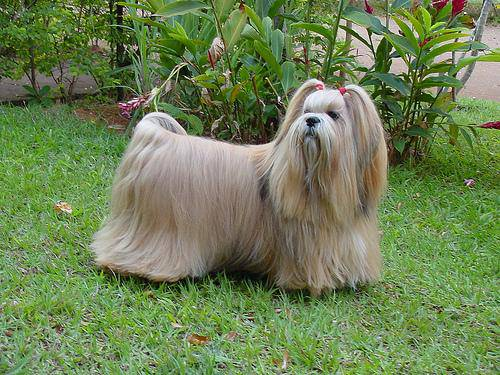

In [5]:
# Check an image
from IPython.display import display, Image
Image('./data/train/0a3f1898556115d6d0931294876cd1d9.jpg')

In [6]:
# Fit and transform the 'breed' column
le = LabelEncoder()
df['encoded_breed'] = le.fit_transform(df['breed'])

df.head()

le = LabelBinarizer()
y = le.fit_transform(df['encoded_breed'])

y.shape

(10222, 120)

In [7]:
# Store pixel values
labels = df["encoded_breed"]
feature_array = []

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_pixels = load_img(row['image_path'], target_size=(32, 32, 3))
    img_pixels = img_to_array(img_pixels)
    img_pixels = img_pixels.ravel().reshape(1, -1)

    row_data = pd.DataFrame(
        img_pixels, columns=[f"pixel {i}" for i in range(len(img_pixels[0]))]
    )
    feature_array.append(row_data)

feature_array

100%|██████████████████████████████████████████████████████| 10222/10222 [00:27<00:00, 371.08it/s]


[   pixel 0  pixel 1  pixel 2  pixel 3  pixel 4  pixel 5  pixel 6  pixel 7  \
 0    187.0    153.0    115.0    218.0    200.0    152.0    192.0    163.0   
 
    pixel 8  pixel 9  ...  pixel 3062  pixel 3063  pixel 3064  pixel 3065  \
 0     85.0    113.0  ...        48.0       181.0       119.0        62.0   
 
    pixel 3066  pixel 3067  pixel 3068  pixel 3069  pixel 3070  pixel 3071  
 0       203.0       145.0        99.0       119.0        61.0        37.0  
 
 [1 rows x 3072 columns],
    pixel 0  pixel 1  pixel 2  pixel 3  pixel 4  pixel 5  pixel 6  pixel 7  \
 0     52.0     26.0     11.0     93.0     43.0     18.0     74.0     37.0   
 
    pixel 8  pixel 9  ...  pixel 3062  pixel 3063  pixel 3064  pixel 3065  \
 0     21.0     47.0  ...         6.0       122.0        57.0        19.0   
 
    pixel 3066  pixel 3067  pixel 3068  pixel 3069  pixel 3070  pixel 3071  
 0        54.0        22.0         7.0        51.0        27.0        23.0  
 
 [1 rows x 3072 columns],
    pixe

In [8]:
# Convert to dataframe
features = pd.concat(feature_array, ignore_index=True)
features

,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,...,pixel 3062,pixel 3063,pixel 3064,pixel 3065,pixel 3066,pixel 3067,pixel 3068,pixel 3069,pixel 3070,pixel 3071
0,187.0,153.0,115.0,218.0,200.0,152.0,192.0,163.0,85.0,113.0,...,48.0,181.0,119.0,62.0,203.0,145.0,99.0,119.0,61.0,37.0
1,52.0,26.0,11.0,93.0,43.0,18.0,74.0,37.0,21.0,47.0,...,6.0,122.0,57.0,19.0,54.0,22.0,7.0,51.0,27.0,23.0
2,109.0,108.0,104.0,106.0,106.0,104.0,49.0,35.0,26.0,186.0,...,109.0,127.0,128.0,123.0,76.0,76.0,74.0,103.0,102.0,98.0
3,95.0,104.0,99.0,78.0,79.0,71.0,48.0,48.0,48.0,48.0,...,97.0,142.0,151.0,120.0,99.0,95.0,68.0,146.0,136.0,111.0
4,82.0,84.0,81.0,81.0,83.0,80.0,97.0,98.0,92.0,86.0,...,90.0,95.0,95.0,93.0,96.0,96.0,94.0,74.0,76.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10217,202.0,203.0,205.0,201.0,201.0,203.0,204.0,204.0,206.0,203.0,...,167.0,172.0,173.0,168.0,173.0,174.0,169.0,173.0,174.0,169.0
10218,177.0,171.0,173.0,174.0,163.0,169.0,174.0,168.0,172.0,169.0,...,167.0,177.0,174.0,181.0,171.0,168.0,175.0,169.0,167.0,170.0
10219,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,198.0,207.0,210.0,215.0,182.0,185.0,190.0,192.0,200.0,203.0
10220,176.0,170.0,170.0,180.0,170.0,171.0,185.0,175.0,176.0,185.0,...,175.0,155.0,156.0,161.0,164.0,171.0,181.0,105.0,105.0,117.0


In [9]:
# Train-Validation splitting
X_train, X_val, y_train, y_val = train_test_split(
    features.to_numpy(), 
    labels.to_numpy(), 
    test_size=0.2
)
 
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8177, 3072), (2045, 3072), (8177,), (2045,))

# Machine Learning

In [11]:
# Load model from digit-recognizer
log_req_model = joblib.load('../digit-recognizer/logistic_regression_model.joblib')
knn_model = joblib.load('../digit-recognizer/knn_model.joblib')

## Logistic Regression

In [12]:
# Fit the loaded model
log_req_model.fit(X_train, y_train)

LogisticRegression()

In [13]:
# Predict & Accuracy
y_pred_log = log_req_model.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_pred_log)}')

Accuracy: 0.033251833740831294


> With the simplest Logistics Regression model, we got very low accuracy: 3.32%

## KNN

In [14]:
# Fit the loaded model
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [15]:
# Predict & Accuracy
y_pred_knn = knn_model.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_pred_knn)}')

Accuracy: 0.026405867970660146


> With the non-linear KNN model, we got also a low accuracy: 2.64%

# Deep Learning

## CNN

In [16]:
# Breed dictionary and mapping to numbers 
breeds = sorted(df["breed"].unique().tolist())
breeds_dict = dict(zip(breeds, range(len(breeds))))

breeds_dict

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [17]:
# Process images to new size
def image_processing(data, image_size):
    X = np.zeros(
        [len(data), image_size[0], image_size[1], image_size[2]],
        dtype=np.uint8,
    )
    y = np.zeros([len(data), 1], dtype=np.uint8)
    for idx, row in tqdm(data.iterrows(), total=data.shape[0]):
        img_pixels = load_img(row['image_path'], target_size=image_size)
        X[idx] = img_pixels
        y[idx] = breeds_dict[row['breed']]
    return X, y

X, y = image_processing(df, (224, 224, 3))
X.shape, y.shape

100%|██████████████████████████████████████████████████████| 10222/10222 [00:21<00:00, 482.65it/s]


((10222, 224, 224, 3), (10222, 1))

In [18]:
# Transfer learning using MobileNetV2
def extract_feature(image_size: tuple, data):
    input_layer = Input(image_size)
    processor = Lambda(preprocess_input)(input_layer)
    base_model = MobileNetV2(
        weights="imagenet", include_top=False, input_shape=image_size
    )(processor)
    maxPool = MaxPooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=maxPool)
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    return feature_maps

features = extract_feature((224, 224, 3), X)
features.shape

160/160 [==============================] - 76s 471ms/step


(10222, 3, 3, 1280)

In [19]:
# Base model by InceptionV3
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# One Hot Encoding to label
y_encoded = tf.keras.utils.to_categorical(y, 120)

y_encoded.shape

(10222, 120)

In [24]:
# Train-Validation splitting
X_train, X_val, y_train, y_val = train_test_split(features, y_encoded, test_size=0.2, random_state=12)
X_train = X_train / 255.0
X_val = X_val / 255.0

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8177, 3, 3, 1280), (2045, 3, 3, 1280), (8177, 120), (2045, 120))

In [25]:
# Define layers
model = Sequential([
    Input(X_train.shape[1:]),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(len(breeds), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               2949376   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 120)               15480     
                                                                 
Total params: 2997752 (11.44 MB)
Trainable params: 2997752 (11.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Train model with epoch=20
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
)

Epoch 1/20
128/128 [==============================] - 2s 10ms/step - loss: 3.7883 - accuracy: 0.2012 - val_loss: 2.0868 - val_accuracy: 0.4836
Epoch 2/20
128/128 [==============================] - 1s 10ms/step - loss: 1.6063 - accuracy: 0.5637 - val_loss: 1.2525 - val_accuracy: 0.6421
Epoch 3/20
128/128 [==============================] - 1s 10ms/step - loss: 1.1016 - accuracy: 0.6815 - val_loss: 1.0322 - val_accuracy: 0.6895
Epoch 4/20
128/128 [==============================] - 1s 11ms/step - loss: 0.8755 - accuracy: 0.7384 - val_loss: 0.9451 - val_accuracy: 0.7159
Epoch 5/20
128/128 [==============================] - 1s 10ms/step - loss: 0.7359 - accuracy: 0.7751 - val_loss: 0.9106 - val_accuracy: 0.7271
Epoch 6/20
128/128 [==============================] - 1s 10ms/step - loss: 0.6139 - accuracy: 0.8148 - val_loss: 0.8738 - val_accuracy: 0.7355
Epoch 7/20
128/128 [==============================] - 1s 10ms/step - loss: 0.5362 - accuracy: 0.8356 - val_loss: 0.8616 - val_accuracy: 0.7413

> Here the accuracy for using CNN is: 76.23%

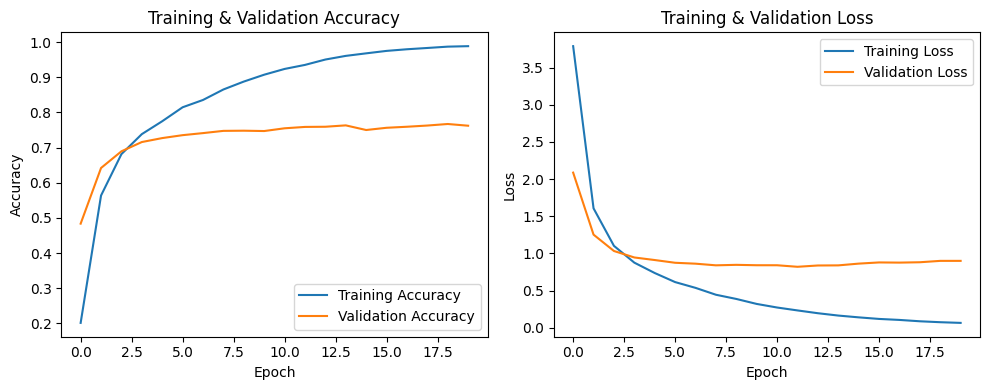

In [27]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Conclusion

> We have comparison for Accuracy:
> 1. (Baseline) Logistics Regression: 3.32%
> 2. KNN: 2.64%
> 3. CNN: 76.23%